# Sentiment based Analysis

In [1]:
#!pip install TextBlob

In [2]:
#!pip install pyspellchecker

In [3]:
#!pip install --upgrade scikit-learn

In [4]:
#!pip install xgboost

In [5]:
#!pip install --upgrade spacy

In [6]:

!pip install plotly

In [7]:
import json 
import numpy as np
import pandas as pd

import re, nltk, string
import spacy
import en_core_web_sm
nlp = spacy.load('en_core_web_sm',  disable=["parser", "ner"])
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk.tokenize import word_tokenize
from collections import Counter
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# import spellchecker
# from spellchecker import SpellChecker

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from imblearn.over_sampling import SMOTE

# Import pickle to save and load the model
import pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
# from sklearn.metrics import plot_roc_curve
# Importing LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression

# Importing Random Forest Classifier from sklearn
from sklearn.ensemble import RandomForestClassifier

# importing libraries for XGBoost classifier
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics.pairwise import pairwise_distances

from pprint import pprint
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Satya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Satya\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Reading Data

In [8]:
df = pd.read_csv("sample30.csv")
df.head(5)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [9]:
# shape of data
df.shape

(30000, 15)

In [10]:
#size of data
df.size

450000

In [11]:
#columns names
df.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating',
       'reviews_text', 'reviews_title', 'reviews_userCity',
       'reviews_userProvince', 'reviews_username', 'user_sentiment'],
      dtype='object')

In [12]:
#info about datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

## Step2: Data Cleaing and EDA

In [13]:
p = df.columns[(df.isnull().any())].tolist()
## To check the percentgae of null values present in each column of our dataset
for i in p:
    print(i,"\t",df[i].isnull().sum()/int(df.shape[0]) *100.0)    

manufacturer 	 0.47000000000000003
reviews_date 	 0.15333333333333335
reviews_didPurchase 	 46.89333333333333
reviews_doRecommend 	 8.566666666666666
reviews_title 	 0.6333333333333333
reviews_userCity 	 93.57
reviews_userProvince 	 99.43333333333332
reviews_username 	 0.21
user_sentiment 	 0.0033333333333333335


In [14]:
# creating 2 list 1 more than 40% null value and 2 less than 40%
# we will drop for more than 40%
# we will check for null value less than 40% ,using fillna method we will substitute value.
col_to_drop=[]
col_to_fill=[]
for i in p:
     val = df[i].isnull().sum()/int(df.shape[0]) *100.0
     if val > 40  :
        col_to_drop.append(i)
     elif val <= 40 :
        col_to_fill.append(i)   

In [15]:
col_to_drop

['reviews_didPurchase', 'reviews_userCity', 'reviews_userProvince']

In [16]:
## Dropping those columns which have null values > 40%
df.drop(col_to_drop,inplace=True,axis=1)

In [17]:
df.shape

(30000, 12)

In [18]:
# after dropping checking for null values
df.isnull().sum()

id                        0
brand                     0
categories                0
manufacturer            141
name                      0
reviews_date             46
reviews_doRecommend    2570
reviews_rating            0
reviews_text              0
reviews_title           190
reviews_username         63
user_sentiment            1
dtype: int64

In [19]:
df=df[~df['manufacturer'].isna()]
df=df[~df['reviews_date'].isna()]
df=df[~df['reviews_title'].isna()]
df=df[~df['user_sentiment'].isna()]
df=df[~df['reviews_username'].isna()]

In [20]:
df.isnull().sum()

id                        0
brand                     0
categories                0
manufacturer              0
name                      0
reviews_date              0
reviews_doRecommend    2336
reviews_rating            0
reviews_text              0
reviews_title             0
reviews_username          0
user_sentiment            0
dtype: int64

In [21]:
df.shape

(29566, 12)

#### As the columns reviews_doRecommend have max null values hence dropping it and not necessary for our modal building.

In [22]:
df = df.drop(['reviews_doRecommend'],axis=1)

In [23]:
df.shape

(29566, 11)

In [24]:
df.head(5)

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,Good flavor.,Good,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative


## Exploratory Data Analysis

### Checking Distribution of `reviews_rating` column

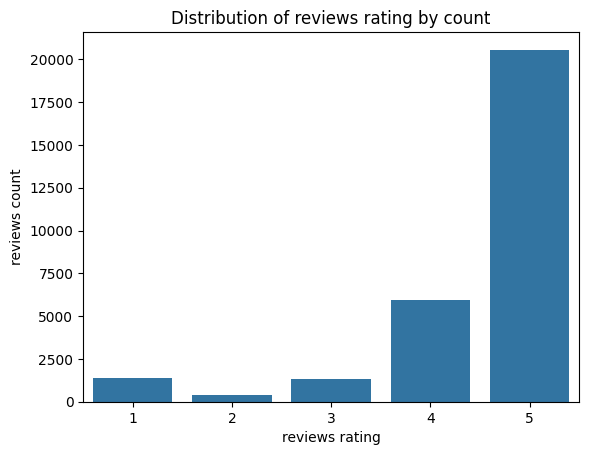

In [25]:
sns.countplot(x = 'reviews_rating', data = df).set(title="Distribution of reviews rating by count", xlabel="reviews rating", ylabel="reviews count")
plt.show()

#### Insights:<br/>
Most of the ratings from the users have been on the higher side. Most of the review ratings have been 5. This would surely cause a data imbalance as user_sentiment should be in alignment with the ratings. We will check and handle data imbalance using smote technique lter on.

### Checking Top 5 Brands with negative reviews

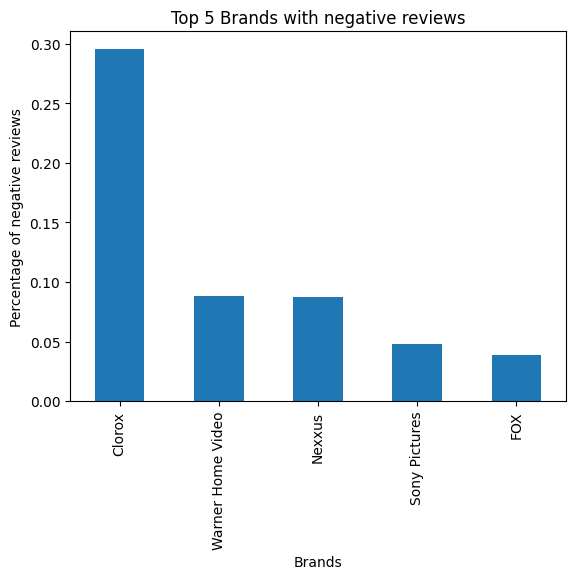

In [26]:
df[ df.user_sentiment == 'Negative' ].brand.value_counts(normalize=True, ascending=False).head(5).plot(kind='bar')
plt.title("Top 5 Brands with negative reviews")
plt.xlabel("Brands")
plt.ylabel("Percentage of negative reviews")
plt.show()

#### INSIGHTS:
Clorox is the product that is rated the most negative and nearly 30% of the negative reviews have been towards Clorox.

In [27]:
#checking for data
df['brand'].value_counts(normalize = True)

brand
Clorox                   0.357302
Warner Home Video        0.112426
Disney                   0.040452
L'oreal Paris            0.040114
FOX                      0.030001
                           ...   
Rizzy Home               0.000034
Pacific Natural Foods    0.000034
Noosa                    0.000034
Southern Enterprises     0.000034
Universal Music          0.000034
Name: proportion, Length: 197, dtype: float64

#### INSIGHTS:
* Surprisingly `Clorox` is the product that is rated the most positive as well and more than 35% of the positive reviews have been towards `Clorox`.
* Checking the data, we realize that 35% of the brands for which we have the data is actually `Clorox` which is why it has the most reviews.

### Checking review counts based on the review year

In [28]:
# Converting review_date to datetime before doing analysis
df['reviews_date'] = pd.to_datetime(df['reviews_date'], errors='coerce')

In [29]:
# Getting year component from date
year = df.reviews_date.dt.year
month = df.reviews_date.dt.month

In [30]:
year

0        2012.0
1        2017.0
2        2017.0
3        2016.0
4        2016.0
          ...  
29995    2017.0
29996    2017.0
29997    2017.0
29998    2017.0
29999    2017.0
Name: reviews_date, Length: 29566, dtype: float64

In [31]:
month

0        11.0
1         7.0
2         7.0
3         1.0
4        12.0
         ... 
29995     1.0
29996     1.0
29997     1.0
29998     1.0
29999     1.0
Name: reviews_date, Length: 29566, dtype: float64

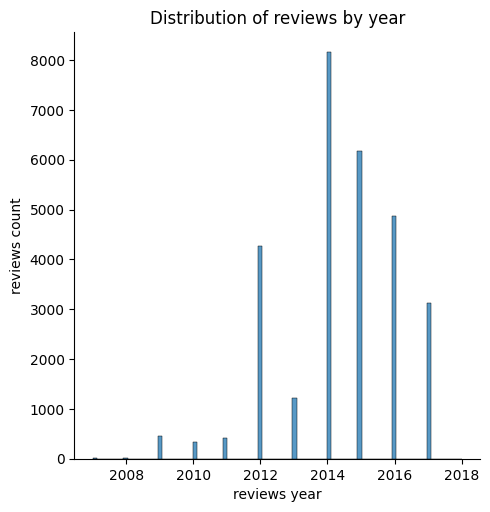

In [32]:
# Creating a distribution plot based on reviews year 
sns.displot(data=df, x=df.reviews_date.dt.year).set(title="Distribution of reviews by year", xlabel="reviews year", ylabel="reviews count")
plt.show()

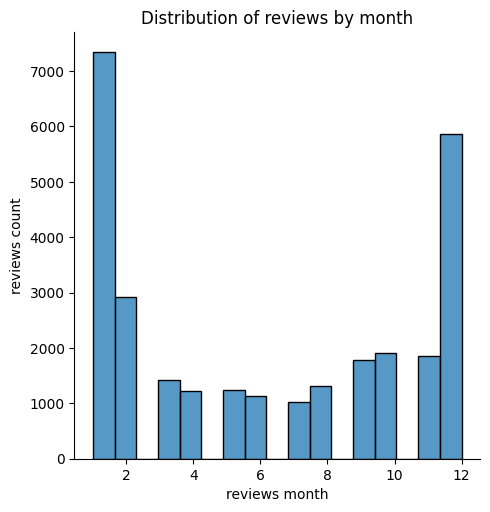

In [33]:
# Creating a distribution plot based on reviews year 
sns.displot(data=df, x=df.reviews_date.dt.month).set(title="Distribution of reviews by month", xlabel="reviews month", ylabel="reviews count")
plt.show()

### Checking Movie categories by Rating

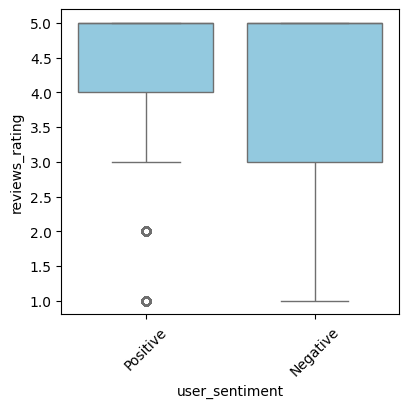

In [34]:
plt.figure(figsize = [5,5])

sns.boxplot(data=df, x='user_sentiment', y='reviews_rating', color='skyblue')
plt.xticks(rotation = 45)

plt.tight_layout(pad = 4)
plt.show()

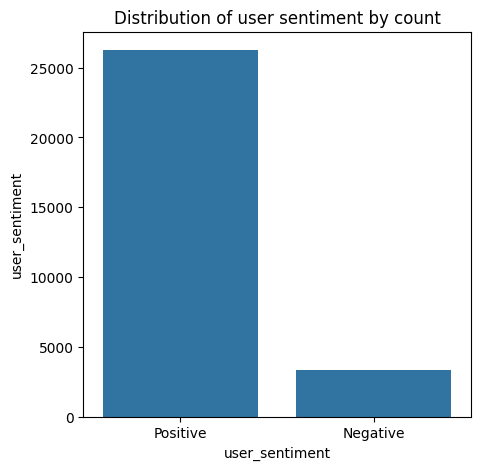

In [35]:
plt.figure(figsize = [5,5])
sns.countplot(x = 'user_sentiment', data = df).set(title="Distribution of user sentiment by count", xlabel="user_sentiment", ylabel="user_sentiment")
plt.show()

#### INSIGHTS:
Positive user sentiments are much more than Negative sentiments.But we have to apply class imblance techniques before procceding.

In [36]:
df[ (df.user_sentiment == 'Negative') & (df.reviews_rating >= 4) ].groupby(['reviews_rating']).count().user_sentiment

reviews_rating
4     535
5    1839
Name: user_sentiment, dtype: int64

#### INSIGHTS:
* It's surprising to note that there are brands which have Negative sentiments but much higher review ratings (4 or 5). There are 2396 such records.
* It might be a data anomaly or there might be a data lag between when the rating was provided and user sentiment given later after use.
* For the purpose of this specific business problem, we will treat this specific analysis as out of scope and move further with the pre-processing steps.

### DataType Conversion

Before we start the pre-processing steps, we need to make sure that all the text columns are converted to string type for future text operations.

In [37]:
# Convert all the text columns to string for performing text operations
df['brand'] = df['brand'].astype(str)
df['categories'] = df['categories'].astype(str)
df['manufacturer'] = df['manufacturer'].astype(str)
df['name'] = df['name'].astype(str)
df['reviews_text'] = df['reviews_text'].astype(str)
df['reviews_title'] = df['reviews_title'].astype(str)
df['reviews_username'] = df['reviews_username'].astype(str)

## Step 3 Data Pre-Processing

#### Combining reviews_text and reviews_title columns into reviews_combined and dropping the initial fields

In [38]:
df['reviews_combined'] = df['reviews_text'] + " " + df['reviews_title']
df.drop(columns=['reviews_text', 'reviews_title'], inplace=True)

In [39]:
df.shape

(29566, 10)

In [40]:
df.head(1)

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_username,user_sentiment,reviews_combined
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30 06:21:45+00:00,5,joshua,Positive,i love this album. it's very good. more to the...


## Removing columns unneeded for analysis

In [41]:
df.drop(columns=['categories', 'manufacturer', 'reviews_date'], inplace=True)
df.head(1)

,id,brand,name,reviews_rating,reviews_username,user_sentiment,reviews_combined
0,AV13O1A8GV-KLJ3akUyj,Universal Music,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua,Positive,i love this album. it's very good. more to the...


In [42]:
df_sent = df[['id','name','reviews_combined', 'user_sentiment']]

In [43]:
df_sent.shape

(29566, 4)

In [44]:
df_sent.head(2)

,id,name,reviews_combined,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),i love this album. it's very good. more to the...,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor. This review was collected as part...,Positive


## Handling punctuations

In [45]:
# Function to clean the text and remove all the unnecessary elements.
def clean_punctuation(sent):
    sent = sent.lower() # Text to lowercase
    pattern = '[^\w\s]' # Removing punctuation
    sent = re.sub(pattern, '', sent)
    return sent

In [46]:
df_sent['reviews_cleaned'] = df_sent['reviews_combined'].apply(clean_punctuation)

In [47]:
df_sent.head(2)

,id,name,reviews_combined,user_sentiment,reviews_cleaned
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),i love this album. it's very good. more to the...,Positive,i love this album its very good more to the hi...
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor. This review was collected as part...,Positive,good flavor this review was collected as part ...


## Handling stopwords

In [48]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Satya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [49]:
from nltk.corpus import stopwords
stopwords_set = set(stopwords.words("english"))
print(stopwords_set)

{'out', 'what', 'me', 'is', 'how', 'more', 'yours', 'were', 'can', 'or', 'i', 'no', 'wouldn', 'again', 'off', 'against', 'those', 'your', 'only', 'll', 'whom', "don't", 'yourselves', 'as', 'herself', 'did', 'ma', 'both', "you'll", 'had', "hasn't", 'at', 'while', 'than', 'just', 'doing', 'the', 'once', 'my', 'until', "that'll", 'all', 'now', 'ain', 'for', 'over', "you've", 'by', 'between', 'having', 'any', 'does', "mustn't", 'shan', 'didn', 'with', "it's", 'there', "weren't", 'most', 'don', 'above', 'been', "shouldn't", 'other', "she's", 'who', 'm', 'aren', 'such', 'weren', 'to', 'him', 'hers', 'about', 'here', 'of', 'am', 'some', 'after', 're', 'and', 'won', 'own', 'that', "hadn't", "haven't", "wasn't", 'into', "should've", 'shouldn', 'are', 'will', 'his', 'these', 'has', 'y', 'them', "needn't", 'which', 'yourself', 'itself', 'too', 'during', "aren't", 't', 'hadn', "mightn't", 'their', 'o', "you'd", 'they', 'be', 'needn', 'down', 'very', "won't", 'each', 'you', "doesn't", 'haven', 'd',

In [50]:
# Function to remove the stopwords
def clean_stopwords(sent):
    sent = sent.lower() # Text to lowercase
    words = word_tokenize(sent) # Split sentences into words
    text_nostopwords = " ".join( [each_word for each_word in words if each_word not in stopwords_set] )
    return sent

In [51]:
df_sent['reviews_cleaned'] = df_sent['reviews_cleaned'].apply(clean_stopwords)

In [52]:
df_sent.head(2)

,id,name,reviews_combined,user_sentiment,reviews_cleaned
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),i love this album. it's very good. more to the...,Positive,i love this album its very good more to the hi...
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor. This review was collected as part...,Positive,good flavor this review was collected as part ...


## Handling lemmatization

In [53]:
#Function to lemmatize the text
def clean_lemma(text):
    sent = []
    doc = nlp(text)
    for token in doc:
        sent.append(token.lemma_)
    return " ".join(sent)

In [54]:
df_sent['reviews_lemmatized'] = df_sent['reviews_cleaned'].apply(clean_lemma)

In [55]:
df_sent.head(2)

,id,name,reviews_combined,user_sentiment,reviews_cleaned,reviews_lemmatized
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),i love this album. it's very good. more to the...,Positive,i love this album its very good more to the hi...,I love this album its very good more to the hi...
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor. This review was collected as part...,Positive,good flavor this review was collected as part ...,good flavor this review be collect as part of ...


In [56]:
df_sent = df_sent[['id','name','reviews_lemmatized', 'user_sentiment']]

In [57]:
df_sent.head(2)

,id,name,reviews_lemmatized,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),I love this album its very good more to the hi...,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,good flavor this review be collect as part of ...,Positive


In [58]:
# from textblob import SpellChecker
# spell = SpellChecker()

In [59]:
# def correct_spelling(text):
#   spell_correctedlist = []
#   words = word_tokenize(text) # Split sentences into words
#   misspelled_words = spell.unknown(words)
#   for each_word in words:
#     # Ignore words which are greater than 13 characters
#     if len(each_word) > 13:
#       continue
#     elif each_word in misspelled_words :
#       # Spell correction 
#       corrected_word = spell.correction(each_word)
#       spell_correctedlist.append(corrected_word)
#     else:
#       # If word is not part of misspelled words, then no alteration is required
#       spell_correctedlist.append(each_word)
#   return " ".join(spell_correctedlist)

In [60]:
# df['reviews_corrected'] = df['reviews_lemmatized'].apply(correct_spelling)

INSIGHTS:
* The spell correction functionality ran for a very long time and did not produce results.
* Even when optimized to correct words less than 13 characters, it is still taking longer.
* For the purpose of this specific assignment, we will ignore the spell correction exercise.

In [61]:
import joblib
joblib.dump(df_sent, open("./static/pickle/clean_data.pkl","wb"))

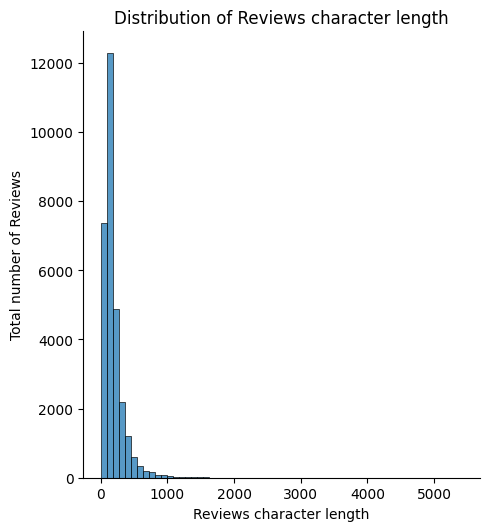

In [62]:
# Visualizing 'reviews_lemmatized' character length
character_length = [len(each_sent) for each_sent in df_sent['reviews_lemmatized']]

sns.displot(character_length, kind='hist', bins=60)
plt.xlabel("Reviews character length")
plt.ylabel("Total number of Reviews")
plt.title("Distribution of Reviews character length")
plt.show()

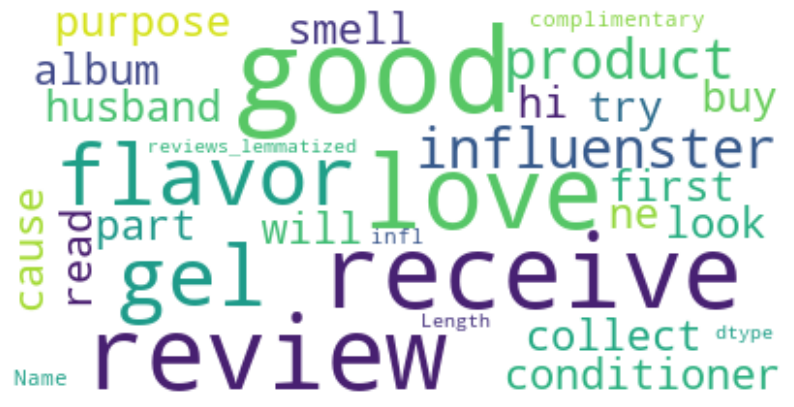

In [63]:
#Using a word cloud visualize the top 30 words in review by frequency
stopwords_wordcloud = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=60, max_words=30, 
                      background_color="white", random_state=42, 
                      stopwords=stopwords_wordcloud).generate(str(df_sent['reviews_lemmatized']))
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Feature Extraction

In this part, we will be performing
1. Feature Extraction using TF-IDF
2. Check for and handle Class imbalance
3. Perform train, test split

## TF-IDF Feature Extraction

**Feature Extraction using TF-IDF**
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 5 means "ignore terms that appear in less than 5 complaints"

In [64]:
# Initialize the TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5, max_df=0.95, stop_words='english', ngram_range=(1,2))

In [65]:
X = tfidf.fit_transform(df_sent['reviews_lemmatized'])
y= df_sent['user_sentiment']

#### creating pickle file of tfidf

In [66]:
import joblib
# Saving the the tfidf vectorizer model
joblib.dump(tfidf, open("./static/models/tfidf.pkl","wb"))

## Train, test split

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

In [68]:
print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (22174, 15891) (22174,)
Test shapes: (7392, 15891) (7392,)


## Class Imbalance

In [69]:
# Check the data to see if there is a class imbalance in the data
df_sent['user_sentiment'].value_counts(normalize=True)

user_sentiment
Positive    0.88825
Negative    0.11175
Name: proportion, dtype: float64

In [70]:
df_sent.head(2)

,id,name,reviews_lemmatized,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),I love this album its very good more to the hi...,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,good flavor this review be collect as part of ...,Positive


From the results above, we can concluded that there is a heavy class imbalance prevalent in the data.
> Positive sentiments make up *89%* of the data and Negative sentiments make up only *11%*

* We are going to handle the imbalance using a technique called SMOTE (Synthetic Minority Oversampling Technique)
* This is an oversampling method that generates synthetic samples for the minority class

In [71]:
counter = Counter(y_train)
print("Before handling imbalance", counter)

#oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train,y_train)

counter = Counter(y_train_sm)
print("After handling imbalance", counter)

Before handling imbalance Counter({'Positive': 19686, 'Negative': 2488})
After handling imbalance Counter({'Positive': 19686, 'Negative': 19686})


Looking at the record count we can see that both Positive and Negative sentiments now have equal number of rows.

# Model Building

We will be creating the following three ML models based on performance for predicting the sentiments based on the text and title of the reviews:
1. Logistic Regression
2. Random Forest
3. XGBoost

In [72]:
# Function to display scores
def evaluation_scores(classifier, X_test, y_test):

  # Calculating Predicted value
  y_pred = classifier.predict(X_test)

  # Create confusion matrix
  conf_m = confusion_matrix(y_test, y_pred)

  print("Visualizing the Confusion Matrix with a Heatmap")
  print("\n")
  print("*"*50)
  # Visualize Confusion Matrix with heatmap
  fig, ax = plt.subplots(figsize=(6, 6))
  ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                  annot=True,
                  cbar=False,
                  cmap="RdYlGn", fmt = '0.1f')
  plt.xlabel("Actual label")
  plt.ylabel("Predicted label")
  plt.show()
  print("*"*50)
  print("\n")

  # Calculating the values of True Positives, True Negatives, False Positivies and False Negatives
  TP = conf_m[1][1]
  TN = conf_m[0][0]
  FP = conf_m[0][1]
  FN = conf_m[1][0]

  print("Values of True Positives, True Negatives, False Positivies and False Negatives")
  print("~"*50)
  print('True Positives:', TP)
  print('True Negatives:', TN)
  print('False Positives:', FP)
  print('False Negatives:', FN)
  print("~"*50)
  print("\n")

  # Calculating Accuracy
  accuracy = accuracy_score(y_test, y_pred)
  accuracy = round(accuracy,2)
  
  # Calculating Sensitivity/Recall
  sensitivity_recall = (TP / float(TP + FN))
  sensitivity_recall = round(sensitivity_recall,2)
  
  # Calculating Specificity
  specificity = (TN / float(TN + FP))
  specificity = round(specificity,2)  
  
  # Calculating Precision
  precision = (TP / float(TP + FP))
  precision = round(precision,2)  
  
  # Calculating F_1 score
  F1_score = 2 * ((precision * sensitivity_recall) / (precision + sensitivity_recall))
  F1_score = round(F1_score,2)  
  
  print("Evaluation Score Summary")
  print('-'*50)
  print(f'Accuracy Score: {round(accuracy,2)}')
  print(f'Sensitivity/Recall Score: {round(sensitivity_recall,2)}') 
  print(f'Specificity Score: {round(specificity,2)}') 
  print(f'Precision: {round(precision,2)}')
  print(f'F1 Score: {round(F1_score,2)}')
  print('-'*50)

  # Returning evaluation results for comparison later
  evaluation_metrics = []
  evaluation_metrics.append(accuracy)
  evaluation_metrics.append(sensitivity_recall)
  evaluation_metrics.append(specificity)
  evaluation_metrics.append(precision)
  evaluation_metrics.append(F1_score)
  
  return evaluation_metrics

## Logistic Regression

Visualizing the Confusion Matrix with a Heatmap


**************************************************


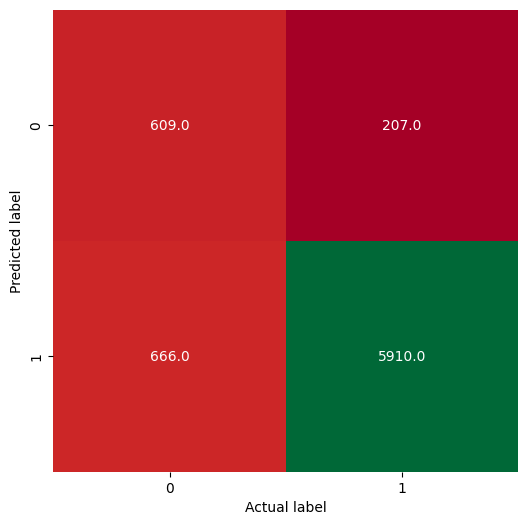

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 5910
True Negatives: 609
False Positives: 207
False Negatives: 666
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.88
Sensitivity/Recall Score: 0.9
Specificity Score: 0.75
Precision: 0.97
F1 Score: 0.93
--------------------------------------------------


In [73]:
logreg = LogisticRegression(random_state=42, solver='liblinear').fit(X_train_sm, y_train_sm)
# Getting the score of the base model
lr_metrics = evaluation_scores(logreg, X_test, y_test)

## HyperParameter Tuning

In [74]:
logreg_grid = {"C": [100, 10, 5, 4, 3, 2, 1, 1.0, 0.1, 0.01],
                "solver": ["liblinear"]}

In [76]:
# Setup grid hyperparameter search for LogisticRegression
logreg_hpt = GridSearchCV(LogisticRegression(random_state=42),
                                param_grid=logreg_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
logreg_hpt.fit(X_train_sm, y_train_sm);

OSError: [Errno 22] Invalid argument

In [ ]:
# Checking the best parameters
logreg_hpt.best_params_

: 

In [ ]:
# Getting the scores of the tuned model
lr_tuned_metrics = evaluation_scores(logreg_hpt, X_test, y_test)

: 

#### creating pickle of Logistic Model file

In [ ]:
lr_base_model = joblib.dump(logreg, open('./static/models/lr_base_model.pkl', 'wb'))

: 

In [ ]:
lr_tuned_model = joblib.dump(logreg_hpt, open('./static/models/lr_tuned_model.pkl', 'wb'))

: 

## Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(random_state=42).fit(X_train_sm, y_train_sm)
# Getting the score of the base model
rf_metrics = evaluation_scores(rf, X_test, y_test)

: 

### HyperParameter Tuning

In [ ]:
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": np.arange(10, 50, 5),
           "min_samples_split": np.arange(15, 500, 15),
           "min_samples_leaf": np.arange(5, 50, 5)}

: 

In [ ]:
# Setup random hyperparameter search for Random Forest Classifier
rf_hpt = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                param_distributions=rf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
rf_hpt.fit(X_train_sm, y_train_sm);

: 

In [ ]:
# Check best parameters
rf_hpt.best_params_

: 

In [ ]:
evaluation_scores(rf_hpt, X_test, y_test)

: 

Sensitivity, Precision and F1 Score have improved a little bit with Random Search CV. We will strive to improve this further by doing fine hyperparameter tuning using Grid Search CV.

In [ ]:
# Fine tuning using Grid Search CV
rf_grid = {"n_estimators": [510],
           "max_depth": [20],
           "min_samples_split": [350, 400],
           "min_samples_leaf": [45, 50]}

: 

In [ ]:
# Setup random hyperparameter search for Random Forest Classifier
rf_hpt = GridSearchCV(RandomForestClassifier(random_state=42),
                                param_grid=rf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
rf_hpt.fit(X_train_sm, y_train_sm);

: 

### HyperParameter tuned model

In [ ]:
# Getting the scores of the tuned model
rf_tuned_metrics = evaluation_scores(rf_hpt, X_test, y_test)

: 

#### Creating Pickle for Random Forest Modal

In [ ]:
rf_base_model = joblib.dump(rf, open('./static/models/rf_base_model.pkl', 'wb'))

: 

In [ ]:
rf_tuned_model = joblib.dump(rf_hpt, open('./static/models/rf_tuned_model.pkl', 'wb'))

: 

**Conclusion:**

For Random Forest, Tuned Model is performing better than the base model as F1 Score is better.
We will consider the Tuned Model for evaluation purpose when we are doing model comparison.

## XGBoost Classifier

In [ ]:
y_test.value_counts()

: 

In [ ]:
y_train_sm = y_train_sm.replace({'Positive':0,'Negative': 1})
y_test = y_test.replace({'Positive':0,'Negative': 1})

: 

In [ ]:
xg = xgb.XGBClassifier(random_state=42).fit(X_train_sm, y_train_sm)
# Getting the score of the base model
xg_metrics = evaluation_scores(xg, X_test, y_test)

: 

### HyperParameter Tuning

In [ ]:
xg_grid = {"learning_rate": np.arange(0.05, 1, 0.1),
           "max_depth": np.arange(5, 20, 5)
           }

: 

In [ ]:
# Setup random hyperparameter search for Random Forest Classifier
xg_hpt = RandomizedSearchCV(XGBClassifier(random_state=42),
                                param_distributions=xg_grid,
                                cv=4,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
xg_hpt.fit(X_train_sm, y_train_sm);

: 

In [ ]:
# Check best parameters
xg_hpt.best_params_

: 

In [ ]:
evaluation_scores(xg_hpt, X_test, y_test)

: 

We will perform further fine tuning with Grid Search CV

In [ ]:
# Fine tuning with Grid Search CV
xg_grid = {"learning_rate": [0.45, 0.15],
           "max_depth": [5, 10]
           }

: 

In [ ]:
# Setup random hyperparameter search for Random Forest Classifier
xg_hpt = GridSearchCV(XGBClassifier(random_state=42),
                                param_grid=xg_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
xg_hpt.fit(X_train_sm, y_train_sm);

: 

In [ ]:
# Check best parameters
xg_hpt.best_params_

: 

In [ ]:
# Getting the scores of the tuned model
xg_tuned_metrics = evaluation_scores(xg_hpt, X_test, y_test)

: 

In [ ]:
#### creating pickle for Xgboost Modal

: 

In [ ]:
xg_base_model = joblib.dump(xg, open('./static/models/xg_base_model.pkl', 'wb'))

: 

In [ ]:
xg_tuned_model = joblib.dump(xg_hpt, open('./static/models/xg_tuned_model.pkl', 'wb'))

: 

***Conclusion:***
* For XG Boost model, Base Model is performing better than the tuned model.
* We will consider the Base Model for evaluation purpose when we are doing model comparison.

# Model Evaluation

In [ ]:
# Printing the scores of all the 3 Models (Base and Tuned)
dict_bt_metrics = {'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'],
                              'LR Base Model': lr_metrics, 'LR Tuned Model': lr_tuned_metrics,
                              'RF Base Model': rf_metrics, 'RF Tuned Model': rf_tuned_metrics,
                              'XG Base Model': xg_metrics, 'XG Tuned Model': xg_tuned_metrics}

df_bt_metrics = pd.DataFrame(dict_bt_metrics, columns = ['Metrics', 'LR Base Model', 'LR Tuned Model', 'RF Base Model', 'RF Tuned Model', 'XG Base Model', 'XG Tuned Model'])
df_bt_metrics

: 

In [ ]:
# Saving the base Random Forest model as the best sentiment model for future use 
best_sentiment_model = joblib.dump(rf_base_model, open('./static/models/best_sentiment_model.pkl', 'wb'))

: 

Looking at the model evaluation metrics and focusing on Sensitivity, Specificity and F1 Score, we can conclude that the base Random Forest Model is the best model out of all of them.

# Building a Recommendation System

We will build the below two recommendation systems
1. User-based recommendation system
2. Item-based recommendation system

Once built, we will analyze the recommendation systems and select the one that is best suited in this case. 
Once we get the best-suited recommendation system, the next task will be to recommend 20 products that a user is most likely to purchase based on the ratings.

## Reading Data

In [ ]:
df_recom = pd.read_csv("sample30.csv")
df_recom.head(2)

: 

In [ ]:
# analysing shape
df_recom.shape

: 

In [ ]:
# We need only the below columns for building a recommendation system
df_recom = df_recom[["id", "name", "reviews_rating", "reviews_username"]]

: 

In [ ]:
# analysing shape
df_recom.shape

: 

## Handling NULL values

In [ ]:
df_recom=df_recom[~df_recom['reviews_username'].isna()]

: 

In [ ]:
df_recom.isnull().sum()

: 

In [ ]:
df_recom.shape

: 

## Train, Test Split

In [ ]:
train, test = train_test_split(df_recom, test_size=0.30, random_state=42)
print(train.shape)
print(test.shape)

: 

In [ ]:
# Pivot the train ratings' dataset into matrix format in which columns are Products and the rows are usernames.
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(0)

df_pivot.head(3)

: 

## Creating dummy train & dummy test dataset

- Dummy train will be used later for prediction of the movies which has not been rated by the user. To ignore the movies rated by the user, we will mark it as 0 during prediction. The movies not rated by user is marked as 1 for prediction in dummy train dataset. 
- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [ ]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

: 

In [ ]:
# The products not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

: 

In [ ]:
# Convert the dummy train dataset into matrix format
dummy_train = dummy_train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(1)

dummy_train.head(3)

: 

**Cosine Similarity**

Cosine Similarity is a measurement that quantifies the similarity between two vectors [Which is `reviews_rating` in this case] 

**Adjusted Cosine**

Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user , we subtract average ratings for each user from each user's rating for different products.



## User Similarity Matrix (Using Adjusted Cosine)

### Here, we are not removing the NaN values and calculating the mean only for the products rated by the user

In [ ]:
# Pivot the train ratings' dataset into matrix format in which columns are Products and the rows are usernames.
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
)

: 

In [ ]:
# For verification purpose, we do have cases where the rating is not NaN
df_pivot[~df_pivot['AV13O1A8GV-KLJ3akUyj'].isna()]

: 

### Normalising the rating of the product for each user around 0 mean

In [ ]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

: 

In [ ]:
df_subtracted.head()

: 

### Finding cosine similarity

In [ ]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

: 

In [ ]:
user_correlation.shape

: 

## Prediction - User User

Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, we will be ignoring the correlation for values less than 0.

In [ ]:
user_correlation[user_correlation<0]=0
user_correlation

: 

Rating predicted by the user (for products rated as well as not rated) is the weighted sum of correlation with the product rating (as present in the rating dataset).

In [ ]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

: 

In [ ]:
user_predicted_ratings.shape

: 

Since we are interested only in the products not rated by the user, we will ignore the products rated by the user by making it zero.

In [ ]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

: 

## Finding the Top 20 products that a user is most likely to purchase based on the ratings (user-user based recommendation)

In [ ]:
# Take a sample username as input.
user_input = '00sab00'

: 

In [ ]:
top20_recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
df_top20_recommendations = pd.DataFrame({'Product Id': top20_recommendations.index, 'cosine_similarity_score' : top20_recommendations})
df_top20_recommendations.reset_index(drop=True, inplace=True)
df_top20_recommendations

: 

In [ ]:
top20_rec = pd.merge(df_recom, df_top20_recommendations,left_on='id',right_on='Product Id', how = 'inner')[['Product Id', 'name', 'cosine_similarity_score']].drop_duplicates()
top20_rec.reset_index(drop=True, inplace=True)
top20_rec.sort_values(by='cosine_similarity_score', ascending=False)

: 

## Evaluation - User User

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the product already rated by the user insead of predicting it for the product not rated by the user.

In [ ]:
train.head(2)

: 

In [ ]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

: 

In [ ]:
common.head(2)

: 

In [ ]:
# convert into the user-product matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')
common_user_based_matrix.head(2)

: 

In [ ]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

: 

In [ ]:
user_correlation_df.head(2)

: 

In [ ]:
df_subtracted.head(1)

: 

In [ ]:
user_correlation_df['userId'] = df_subtracted.index
user_correlation_df.set_index('userId',inplace=True)
user_correlation_df.head(2)

: 

In [ ]:
common.head(1)

: 

In [ ]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_pivot.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

: 

In [ ]:
user_correlation_df_1.shape

: 

In [ ]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

: 

In [ ]:
user_correlation_df_3 = user_correlation_df_2.T
user_correlation_df_3.head()

: 

In [ ]:
user_correlation_df_3.shape

: 

In [ ]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

: 

In [ ]:
common.head(2)

: 

In [ ]:
# Creating dummy test dataframe
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(0)

: 

In [ ]:
dummy_test.shape

: 

In [ ]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

: 

In [ ]:
common_user_predicted_ratings.head(2)

: 

* Calculating the RMSE for only the products rated by user.
* For RMSE, normalising the rating to (1,5) range.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

: 

In [ ]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

: 

In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

: 

RMSE (Root Mean Square Error) for User-User recommendation system

In [ ]:
rmse_user_user = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse_user_user)

: 

## Using Item Similarity

### Item Based Similarity

Taking the transpose of the rating matrix to normalize the rating around the mean for different Product ID. In the user based similarity, we had taken mean for each user instead of each product. 

In [ ]:
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).T

: 

In [ ]:
df_pivot.head()

: 

Normalizing the product rating for each product for using the Adujsted Cosine

In [ ]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

: 

In [ ]:
df_subtracted.head()

: 

Finding the cosine similarity using pairwise distances approach

In [ ]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

: 

Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [ ]:
item_correlation[item_correlation<0]=0
item_correlation

: 

## Prediction - Item Item

In [ ]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

: 

In [ ]:
item_predicted_ratings.shape

: 

In [ ]:
dummy_train.shape

: 

### Filtering the rating only for the products not rated by the user for recommendation

In [ ]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

: 

In [ ]:
# Take a sample username as input.
user_input = '00sab00'

: 

In [ ]:
item_final_rating.head(2)

: 

In [ ]:
top20_item_recommendations = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
df_top20_item_recommendations = pd.DataFrame({'Product Id': top20_item_recommendations.index, 'cosine_similarity_score' : top20_item_recommendations})
df_top20_item_recommendations.reset_index(drop=True, inplace=True)
df_top20_item_recommendations

: 

## Finding the Top 20 products that a user is most likely to purchase based on the ratings (item-item based recommendation)

In [ ]:
top20_item_rec = pd.merge(df_recom, df_top20_item_recommendations,left_on='id',right_on='Product Id', how = 'inner')[['Product Id', 'name', 'cosine_similarity_score']].drop_duplicates()
top20_item_rec.reset_index(drop=True, inplace=True)
top20_item_rec.sort_values(by='cosine_similarity_score', ascending=False)

: 

## Evaluation - Item Item

Evaluation will we same as we have seen above for the prediction. The only difference being, we will evaluate for the product already rated by the user insead of predicting it for the product not rated by the user.

In [ ]:
test.columns

: 

In [ ]:
# Find out the common products of test and train dataset.
common = test[test.id.isin(train.id)]
common.shape

: 

In [ ]:
common.head(2)

: 

In [ ]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T
common_item_based_matrix.shape

: 

In [ ]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head(2)

: 

In [ ]:
item_correlation_df['movieId'] = df_subtracted.index
item_correlation_df.set_index('movieId',inplace=True)
item_correlation_df.head()

: 

In [ ]:
list_name = common.id.tolist()

: 

In [ ]:
item_correlation_df.columns = df_subtracted.index.tolist()
item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]


: 

In [ ]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]
item_correlation_df_3 = item_correlation_df_2.T
item_correlation_df_3.head(2)

: 

In [ ]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

: 

In [ ]:
common_item_predicted_ratings.shape

: 

In [ ]:
common.head(2)

: 

In [ ]:
# Dummy test will be used for evaluation
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

: 

The products not rated are marked as 0 for evaluation

In [ ]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

: 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

: 

In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

: 

RMSE (Root Mean Square Error) for Item-Item recommendation system

In [ ]:
rmse_item_item = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse_item_item)

: 

# Best-suited Recommendation model

* To get the best recommendation model, we will use RMSE (Root Mean Square Error) scores for both user-user and item-item based recommendation systems and do a comparison of the values.
* The recommendation model with the least RMSE will be selected as the best recommendation model.

In [ ]:
# Recommended model evaluation
if rmse_user_user < rmse_item_item:
  print("Best-fit model is user-user recommendation system")
else:
  print("Best-fit model is item-item recommendation system")

: 

# Top 20 Product recommendations to the user by the best recommendation model (user-user based recommendation system)

In [ ]:
# Take a sample username as input
user_input = 'evrydayhustla420'

: 

In [ ]:
top20_recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
df_top20_recommendations = pd.DataFrame({'Product Id': top20_recommendations.index, 'cosine_similarity_score' : top20_recommendations})
df_top20_recommendations.reset_index(drop=True, inplace=True)
df_top20_recommendations

: 

In [ ]:
top20_rec = pd.merge(df_recom, df_top20_recommendations,left_on='id',right_on='Product Id', how = 'inner')[['Product Id', 'name', 'cosine_similarity_score']].drop_duplicates()
top20_rec.reset_index(drop=True, inplace=True)
top20_rec.sort_values(by='cosine_similarity_score', ascending=False)

: 

In [ ]:
user_final_rating.shape

: 

In [ ]:
user_final_rating.head(2)

: 

#### creating a joblib file for best recommendation model

In [ ]:
best_recommendation_model = joblib.dump(user_final_rating.astype('float32'), open('./static/models/best_recommendation_model.pkl', 'wb'))

: 

# Fine-Tuning the Recommendation System and Recommendation of Top 5 Products

In [ ]:
def product_recommendations_user(user_name):
    if user_name not in user_final_rating.index:
        print(f"The User {user_name} does not exist. Please provide a valid user name")
    else:
        # Get top 20 recommended products from the best recommendation model
        top20_recommended_products = list(user_final_rating.loc[user_name].sort_values(ascending=False)[:20].index)
        
        # Get only the recommended products from the prepared dataframe "df_sent"
        df_top20_products = df_sent[df_sent.id.isin(top20_recommended_products)]
        
        # For these 20 products, get their user reviews and pass them through TF-IDF vectorizer to convert the data into suitable format for modeling
        X = tfidf.transform(df_top20_products["reviews_lemmatized"].values.astype(str))
        
        # Use the best sentiment model to predict the sentiment for these user reviews
        df_top20_products['predicted_sentiment'] = logreg.predict(X)
        
        # Create a new column to map Positive sentiment to 1 and Negative sentiment to 0. This will allow us to easily summarize the data
        df_top20_products['positive_sentiment'] = df_top20_products['predicted_sentiment'].apply(lambda x: 1 if x=="Positive" else 0)
        
        # Create a new dataframe "pred_df" to store the count of positive user sentiments
        pred_df = df_top20_products.groupby(by='name').agg({'positive_sentiment': 'sum', 'predicted_sentiment': 'count'})
        
        # Rename columns
        pred_df.columns = ['pos_sent_count', 'total_sent_count']
        
        # Create a column that measures the % of positive user sentiment for each product review
        pred_df['post_sent_percentage'] = np.round(pred_df['pos_sent_count'] / pred_df['total_sent_count'] * 100, 2)
        
        # Return top 5 recommended products to the user
        result = pred_df.sort_values(by='post_sent_percentage', ascending=False).head(5)
        return result




: 

In [ ]:
# Take a sample username as input
user_input = 'charlie'
print(f"Printing the top 5 recommended products for the user: {user_input} along with each product's positive sentiment count, overall review count and positive sentiment %")
print("\n")
top5_reco_sent_reco_user = product_recommendations_user(user_input)
print(top5_reco_sent_reco_user)

: 

In [ ]:
top5_reco_sent_reco_user

: 

In [ ]:
# Showing only the top 5 Product Names for the user
print(f"Printing the top 5 recommended products list for the user: {user_input}")
print(list(top5_reco_sent_reco_user.index))

: 

In [ ]:
top_5_recommendation = joblib.dump(top5_reco_sent_reco_user, open('./static/pickle/top_5_recomendations.pkl', 'wb'))

: 

: 

: 

: 